Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from glob import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print('Train image Count =',image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print('Test image Count =',image_count_test)

Train image Count = 2239
Test image Count = 118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
##creating a tensor data of image using a keras library
## using batch size 32 and seed=123 and resizing the image for training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "training",
    
)
  

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "validation")

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
## resizing test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [9]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

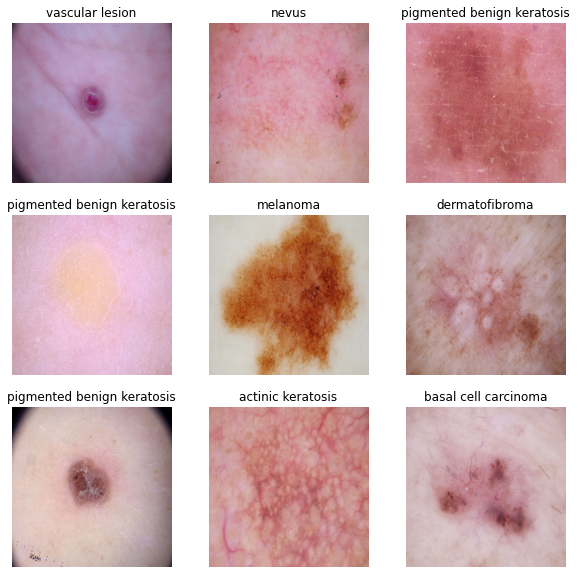

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        temp = labels[i].numpy()
        xr = (np.argmax(temp))
        plt.title(class_names[xr])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [12]:
### Your code goes here
### Building a model without dropout and normalization

input_shape = (180,180,3)
num_classes = 9
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dense(num_classes))
model.add(Activation("softmax"))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [13]:
### Todo, choose an appropirate optimiser and loss function
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 89, 89, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 64)        36928     
                                                        

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 142s 3s/step - loss: 2.2695 - accuracy: 0.2076 - val_loss: 2.0339 - val_accuracy: 0.2550
Epoch 2/20
56/56 [==============================] - 5s 86ms/step - loss: 1.8825 - accuracy: 0.2896 - val_loss: 1.6711 - val_accuracy: 0.4072
Epoch 3/20
56/56 [==============================] - 5s 85ms/step - loss: 1.6046 - accuracy: 0.4007 - val_loss: 1.6451 - val_accuracy: 0.3803
Epoch 4/20
56/56 [==============================] - 5s 85ms/step - loss: 1.4905 - accuracy: 0.4531 - val_loss: 1.6081 - val_accuracy: 0.4720
Epoch 5/20
56/56 [==============================] - 5s 85ms/step - loss: 1.4256 - accuracy: 0.5089 - val_loss: 1.4291 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 5s 85ms/step - loss: 1.3139 - accuracy: 0.5346 - val_loss: 1.5658 - val_accuracy: 0.4564
Epoch 7/20
56/56 [==============================] - 5s 86ms/step - loss: 1.2273 - accuracy: 0.5608 - val_loss: 1.4692 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing training results

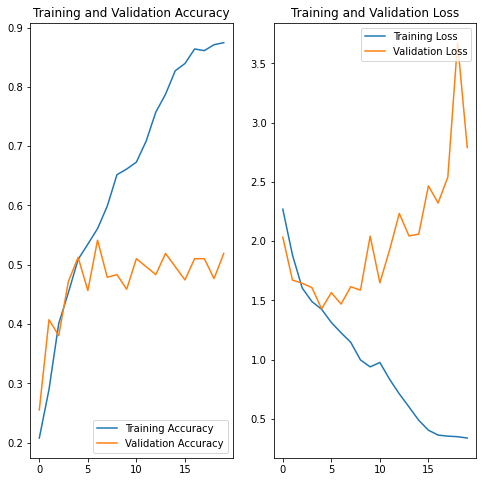

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

- The Training accuracy comes as 87.44 %
- The validation accuracy comes as 51.90 %
- Hence it is a clear case of overfitting where the model does not work well on validation data

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

data_aug = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

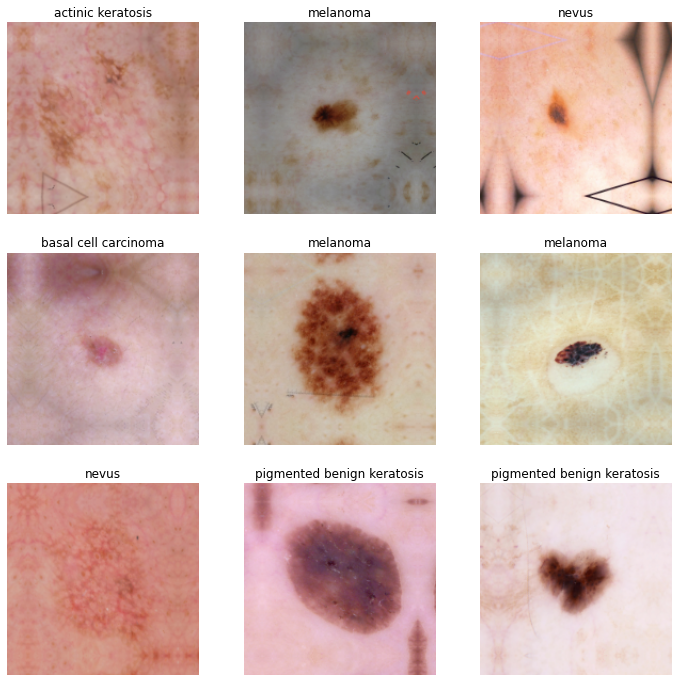

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_aug(images)[i].numpy().astype("uint8"))
        temp = labels[i].numpy()
        xr = (np.argmax(temp))
        plt.title(class_names[xr])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [21]:
## using Dropout layer and few other hyperparameters, since we had an evidence of overfitting


model = Sequential()

#adding the data augmentation layer 
model.add(data_aug)

#rescaling layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


### Compiling the model

In [22]:
## compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 89, 89, 32)        0         
                                                      

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 96ms/step - loss: 2.5776 - accuracy: 0.1842 - val_loss: 2.0210 - val_accuracy: 0.2170
Epoch 2/20
56/56 [==============================] - 5s 95ms/step - loss: 2.0176 - accuracy: 0.2171 - val_loss: 2.0393 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 6s 100ms/step - loss: 2.0308 - accuracy: 0.2059 - val_loss: 2.0422 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 5s 93ms/step - loss: 2.0291 - accuracy: 0.1914 - val_loss: 2.0281 - val_accuracy: 0.2058
Epoch 5/20
56/56 [==============================] - 5s 93ms/step - loss: 1.9990 - accuracy: 0.2176 - val_loss: 1.9313 - val_accuracy: 0.2998
Epoch 6/20
56/56 [==============================] - 5s 94ms/step - loss: 1.9272 - accuracy: 0.2818 - val_loss: 1.8922 - val_accuracy: 0.2796
Epoch 7/20
56/56 [==============================] - 5s 93ms/step - loss: 1.8853 - accuracy: 0.3069 - val_loss: 1.8208 - val_accuracy: 0.2595
Epoch 8/20
5

### Visualizing the results

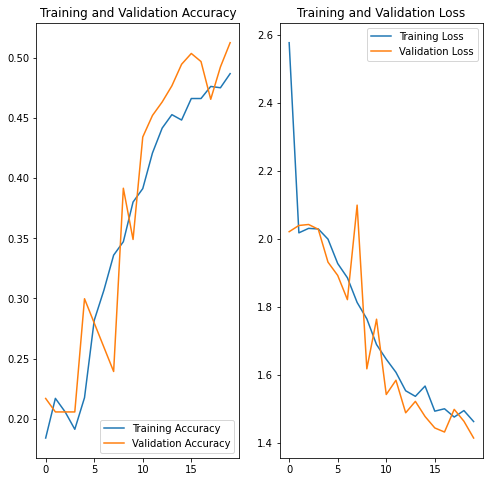

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?
The training accuracy is around 48.66 % and the validation accuracy is around 51.23 %. Now both accuracy are closely alligned and there is no sign of Overfitting. Since the Accuracy is low now we need to improve it.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

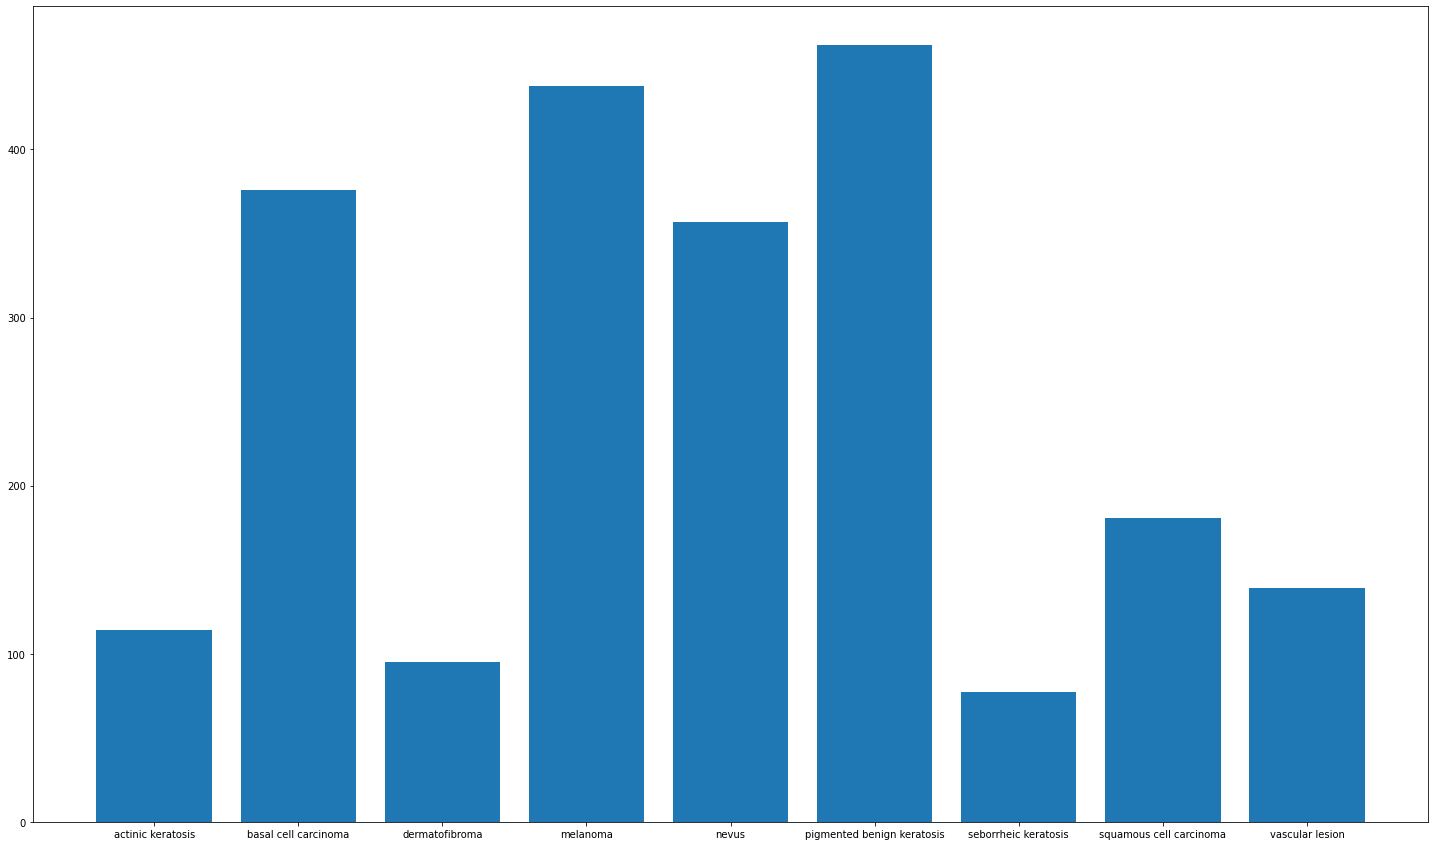

In [25]:
#creating a dataframe and visualizing all classes
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])

dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,15))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? -- Seborrheic keratosis 
#### - Which classes dominate the data in terms proportionate number of samples? -- Pigmented Benign keratosis


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [26]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [27]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BF27924D0>: 100%|██████████| 500/500 [00:19<00:00, 25.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D63606D10>: 100%|██████████| 500/500 [00:22<00:00, 22.10 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9BF2764B90>: 100%|██████████| 500/500 [00:25<00:00, 19.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9BF26C3B10>: 100%|██████████| 500/500 [01:50<00:00,  4.51 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F9BF27A7050>: 100%|██████████| 500/500 [01:31<00:00,  5.49 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9C386F70D0>: 100%|██████████| 500/500 [00:18<00:00, 27.06 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9BF275C390>: 100%|██████████| 500/500 [00:44<00:00, 11.23 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9C3803F150>: 100%|██████████| 500/500 [00:18<00:00, 27.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9D63612890>: 100%|██████████| 500/500 [00:18<00:00, 27.54 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [28]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [29]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030344.jpg_6491298a-487b-4db0-ad47-9ee6a2bc4272.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0033413.jpg_2a58a87f-89ec-4d70-83a4-c9d6b574eca7.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_535f6c66-1614-4484-944b-4a330dc64f13.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026468.jpg_914972de-1186-4929-b363-8dc9051d6485.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026171.jpg_add0ae5f-9e9b-401f-8238-f1aeaa44bcd0.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Data

In [30]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [31]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [32]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [33]:
new_df['Label'].value_counts()

actinic keratosis             500
vascular lesion               500
squamous cell carcinoma       500
nevus                         500
pigmented benign keratosis    500
melanoma                      500
basal cell carcinoma          500
dermatofibroma                500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [34]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [35]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/Melanoma_Detection/Dataset/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "training",
    
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [36]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset = "validation")

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [37]:
#building model with both dropot and normalization in each layer and dropout at end of FC

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation("softmax"))


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [38]:
## compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

## Model Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 180, 180, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 178, 178, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 89, 89, 32)      

#### **Todo:**  Train your model

In [39]:
#Training for 30 epochs
epochs = 30

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds)

Epoch 1/30
169/169 [==============================] - 48s 274ms/step - loss: 3.5607 - accuracy: 0.2825 - val_loss: 5.0175 - val_accuracy: 0.1269
Epoch 2/30
169/169 [==============================] - 35s 200ms/step - loss: 1.5427 - accuracy: 0.4405 - val_loss: 2.8764 - val_accuracy: 0.2658
Epoch 3/30
169/169 [==============================] - 35s 203ms/step - loss: 1.3158 - accuracy: 0.5328 - val_loss: 2.1973 - val_accuracy: 0.4529
Epoch 4/30
169/169 [==============================] - 34s 197ms/step - loss: 1.1571 - accuracy: 0.5835 - val_loss: 1.8752 - val_accuracy: 0.5093
Epoch 5/30
169/169 [==============================] - 34s 197ms/step - loss: 0.9948 - accuracy: 0.6369 - val_loss: 1.2555 - val_accuracy: 0.5791
Epoch 6/30
169/169 [==============================] - 34s 195ms/step - loss: 0.9121 - accuracy: 0.6712 - val_loss: 1.3364 - val_accuracy: 0.5843
Epoch 7/30
169/169 [==============================] - 34s 198ms/step - loss: 0.8275 - accuracy: 0.7012 - val_loss: 0.9050 - val_ac

#### **Todo:**  Visualize the model results

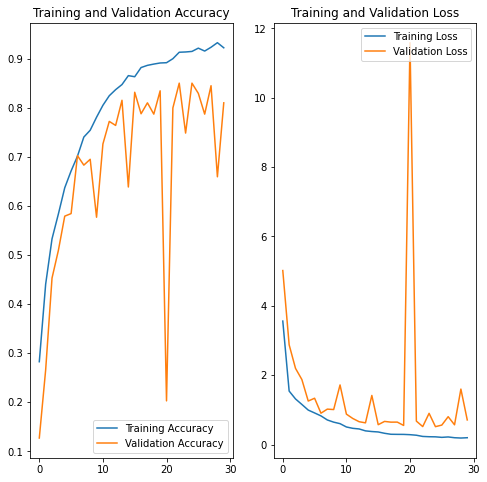

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- class rebalance helps in reducing overfititng of the data and increased the accuracy as well
    - Training Accuracy = 91.47 %
    - Validation Accuracy - 85.00 %

- Model 1 --> Without Dropout and augmentation which created data to overfit at high ratio

- Model 2 --> With Dropout and Augmentation which reduced overfitting but Accuracy dropped drastically

- Model 3 --> With Batch Normalization and Augumentation which provided good results and better accuracy when compared to other models

